In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Function to clean and extract numbers based on formatting
def clean_column_values(value):
    # Check if value is NaN or already a float
    if pd.isna(value):
        return np.nan
    elif isinstance(value, (int, float)):
        return value
    try:
        # If the value contains "of", extract the first number
        if " of " in value:
            return int(value.split(' of ')[0])
        # If the value ends with "%", extract the number and convert to decimal
        elif "%" in value:
            return float(value.strip('%')) / 100
        # Otherwise, try to convert the value to float directly
        else:
            return float(value)
    except (ValueError, AttributeError):
        # Handle unexpected formats by returning None
        return np.nan

# Load the dataset
df = pd.read_csv('ufc_fight_stats.csv')  # Adjust the file path if necessary

# Apply cleaning function to relevant columns
columns_to_clean = ['SIG.STR.', 'SIG.STR. %', 'TOTAL STR.', 'TD', 'TD %', 'CTRL', 'HEAD', 'BODY', 'LEG', 'DISTANCE', 'CLINCH', 'GROUND']
for col in columns_to_clean:
    df[col] = df[col].apply(clean_column_values)

# Proceed with data preparation
def prepare_data(df, n_rounds=15, columns_to_include=['SIG.STR.']):
    rows = []
    
    fighters = df['FIGHTER'].unique()
    
    for fighter in fighters:
        fighter_data = df[df['FIGHTER'] == fighter]
        rounds = fighter_data['ROUND'].unique()
        
        for round_num in rounds:
            current_round_data = fighter_data[fighter_data['ROUND'] == round_num]
            
            if len(current_round_data) == 0:
                continue
            
            past_fighter_data = fighter_data[fighter_data['ROUND'] < round_num].tail(n_rounds)
            
            if len(past_fighter_data) < n_rounds:
                continue

            opponent_data = df[df['FIGHTER'] != fighter]
            opponent_data = opponent_data[opponent_data['ROUND'] == round_num]
            
            if len(opponent_data) == 0:
                continue
            
            opponent_fighter = opponent_data['FIGHTER'].values[0]
            past_opponent_data = df[df['FIGHTER'] == opponent_fighter]
            past_opponent_data = past_opponent_data[past_opponent_data['ROUND'] < round_num].tail(n_rounds)
            
            if len(past_opponent_data) < n_rounds:
                continue
            
            features = []
            
            for col in columns_to_include:
                features += past_fighter_data[col].tolist() + past_opponent_data[col].tolist()
            
            target = current_round_data['SIG.STR.'].values[0]
            
            rows.append(features + [target])
    
    columns = []
    for col in columns_to_include:
        columns += [f'fighter_{col}_round_{i+1}' for i in range(n_rounds)] + \
                   [f'opponent_{col}_round_{i+1}' for i in range(n_rounds)]
    
    columns += ['target']
    
    result_df = pd.DataFrame(rows, columns=columns)
    
    return result_df

# Example usage: including 'SIG.STR.', 'SIG.STR. %', 'TD', etc.
columns_to_include = ['SIG.STR.', 'SIG.STR. %', 'TD']
prepared_df = prepare_data(df, n_rounds=15, columns_to_include=columns_to_include)

# Apply Min-Max scaling
scaler = MinMaxScaler()

X = prepared_df.drop(columns=['target'])
y = prepared_df['target']

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

prepared_df_scaled = pd.concat([X_scaled, y], axis=1)

# Save the scaled DataFrame to CSV
prepared_df_scaled.to_csv('ufc_fight_data_prepared_scaled.csv', index=False)


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Load the prepared dataset
data = pd.read_csv('ufc_fight_data_prepared_scaled.csv')

# Drop rows with missing values
data_clean = data.dropna()

# Separate features and target
X = data_clean.drop(columns=['target'])
y = data_clean['target']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')



Mean Squared Error: 214.4362321580102


In [3]:
def prepare_new_fight_data(fighter1, fighter2, df, n_rounds=15, feature_cols=None):
    # Get data for the fighters
    fighter1_data = df[df['FIGHTER'] == fighter1].tail(n_rounds)
    fighter2_data = df[df['FIGHTER'] == fighter2].tail(n_rounds)
    
    # If either fighter does not have enough data, return None
    if len(fighter1_data) < n_rounds or len(fighter2_data) < n_rounds:
        return None
    
    # Dynamically create feature lists
    if feature_cols is None:
        feature_cols = ['SIG.STR.']  # Default to significant strikes if no feature columns are provided
    
    # Create features for the new fight by extracting the specified columns
    fighter1_features = fighter1_data[feature_cols].values.flatten().tolist()
    fighter2_features = fighter2_data[feature_cols].values.flatten().tolist()
    
    # Combine the features of both fighters
    features = fighter1_features + fighter2_features
    
    return features

# Example usage
fighter1 = 'Sean O\'Malley'
fighter2 = 'Merab Dvalishvili'

# List of columns you want to include as features (e.g., SIG.STR., SIG.STR. %, etc.)

new_fight_features = prepare_new_fight_data(fighter1, fighter2, df, feature_cols=columns_to_include)

# Ensure new_fight_features is not None and has the correct length based on the selected columns
if new_fight_features is not None:
    # Convert to DataFrame for prediction
    new_fight_df = pd.DataFrame([new_fight_features], columns=X.columns)
    
    # Predict the number of significant strikes
    prediction = model.predict(new_fight_df)
    print(f'Predicted Significant Strikes: {prediction[0]}')
else:
    print('Insufficient data for one or both fighters.')


Predicted Significant Strikes: 56.858368013784116


Mean Squared Error: 216.3270336511834


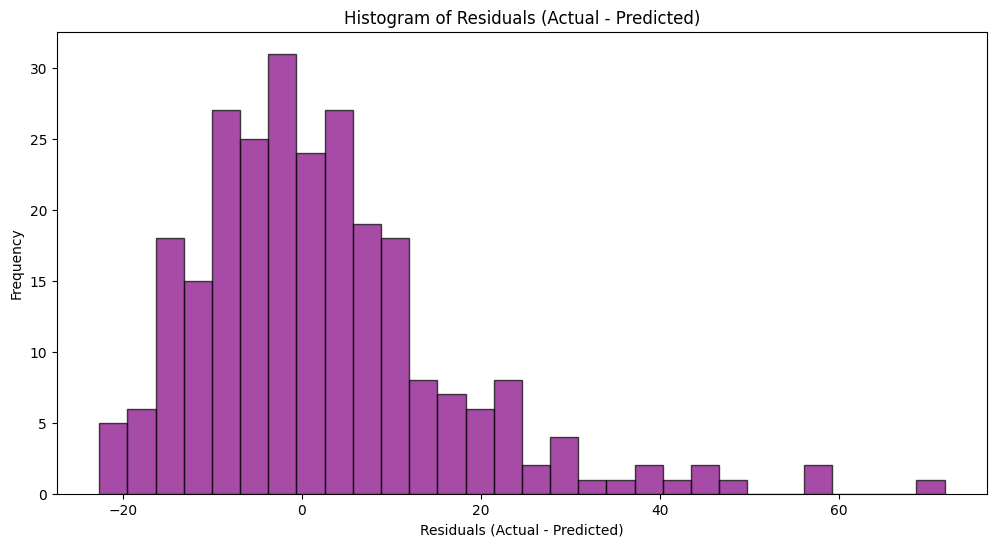

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the prepared dataset
data = pd.read_csv('ufc_fight_data_prepared.csv')

# Remove rows with any missing values
data_cleaned = data.dropna()

# Separate features and target
X = data_cleaned.drop(columns=['target'])
y = data_cleaned['target']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = GradientBoostingRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot histogram of residuals
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Actual - Predicted)')
plt.show()

